In [17]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from config import *
from main import run_trajectory
from simple_decoder_transformer import SimpleDecoderTransformer
from competiclique_the_game import CompetiClique

from copy import deepcopy

builder_states = torch.load("builder_policy_opt.pt")
forbidder_states = torch.load("forbidder_policy_opt.pt")

device = torch.device(DEVICE)

model = SimpleDecoderTransformer(L=LAYERS, H=HEADS, d_e=EMBEDDING_DIM, d_mlp = MLP_DIM).to(device)

game = CompetiClique(clique_size = CLIQUE_SIZE,
                     edges_per_builder_turn=EDGES_PER_BUILDER_TURN,
                     vertices_per_forbidder_turn=VERTICES_PER_FORBIDDER_TURN
                    )

builder_policy = deepcopy(model)#SimpleDecoderTransformer(L = 2, H = 4, d_e = 32, d_mlp = 48)
forbidder_policy = deepcopy(model)#SimpleDecoderTransformer(L = 2, H = 4, d_e = 32, d_mlp = 48)

In [18]:
builder_policy.load_state_dict(builder_states['builder_policy_state_dict'])
forbidder_policy.load_state_dict(forbidder_states['forbidder_policy_state_dict'])

builder_policy.train() # necessary because each action has a batch size of like 1 or 2, so 
forbidder_policy.train() # variance etc is calculated only across the components of the channel vectors
                        # also the correction term decreases the "effective" batch size (not an actual term, just what I'm calling it)
                        # to 1, since each observation is a batch according to the batchnorm layer
print()

In [19]:
trajectory = None
with torch.no_grad():
    trajectory = run_trajectory(game, builder_policy, forbidder_policy, device, evalu=True)
    print(trajectory[-1])

nobody_wins


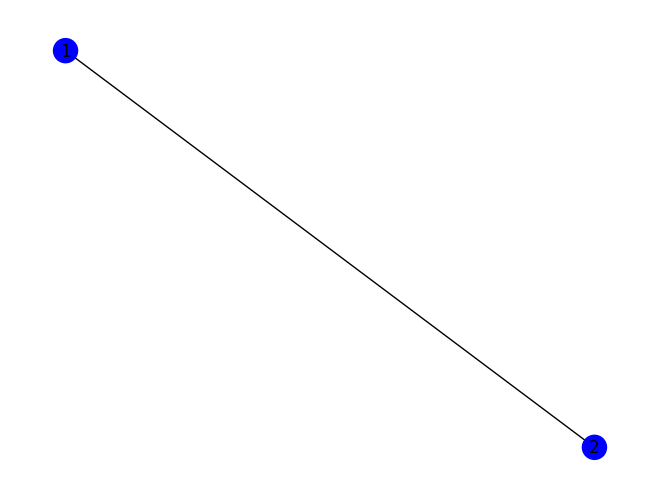

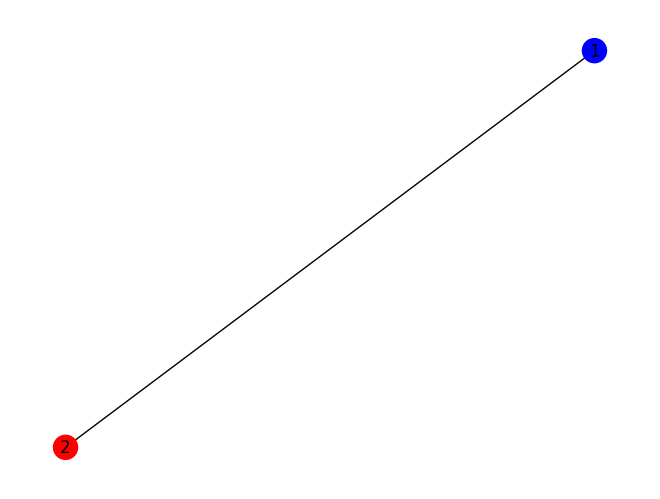

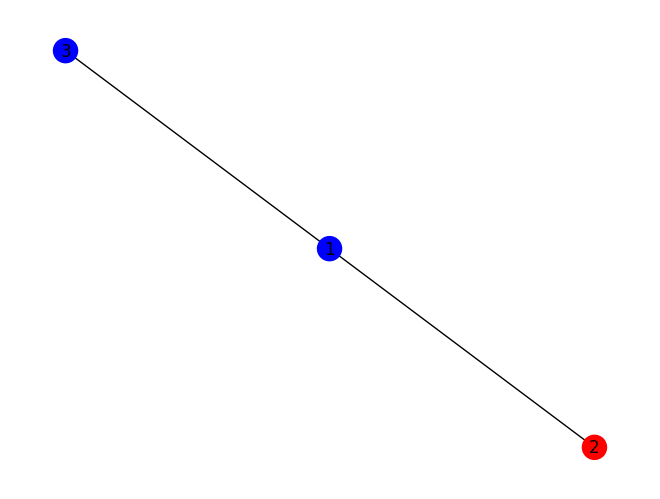

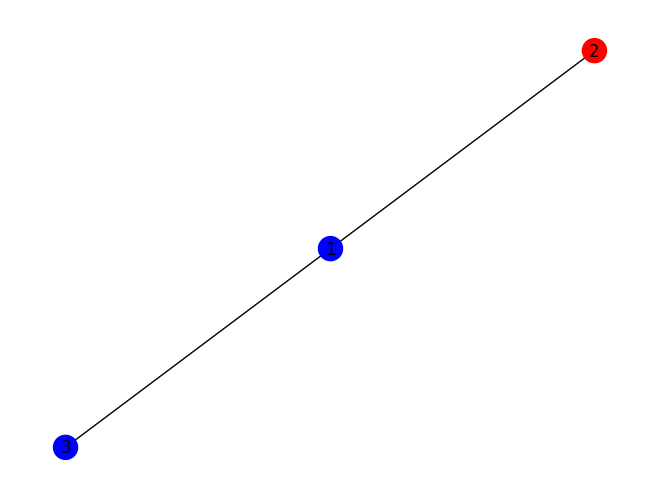

In [20]:
for graph in trajectory[-2]:
    color_map = list('red' if graph.nodes[node]['forbidden'] else 'blue' for node in graph)
    nx.draw(graph, node_color=color_map, with_labels=True)
    plt.show()